In [1]:
%matplotlib inline
import torchvision
import torchvision.datasets as ds
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import os

In [2]:
def imshow(dataset, num_sample_show):
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, num_sample_show
    for r in range(rows):
        random_index = random.randint(0, len(dataset))
        anchor, pos, neg = dataset[random_index]
        col_1 = figure.add_subplot(rows, cols, 3 * r + 1)
        col_1.set_title("anchor")
        plt.axis("off")
        plt.imshow(np.asarray(anchor))
        col_2 = figure.add_subplot(rows, cols, 3 * r + 2)
        col_2.set_title("pos")
        plt.axis("off")
        plt.imshow(np.asarray(pos))
        col_3 = figure.add_subplot(rows, cols, 3 * r + 3)
        col_3.set_title("neg")
        plt.axis("off")
        plt.imshow(np.asarray(neg))
        plt.axis("off")
        
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [3]:
from collections import defaultdict

class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None):   
        self.transform = transform
        self.img_folder_ds = imageFolderDataset
        self.class_index_to_img_index_dict = self.get_classnames_to_class_index_dict()
        self.class_index = list(self.class_index_to_img_index_dict.keys())
        
    def get_classnames_to_class_index_dict(self):
        class_index_to_img_index_dict = defaultdict(list)
        for img, label in self.img_folder_ds:
            class_index_to_img_index_dict[label].append(img)
        return class_index_to_img_index_dict
        
    def __getitem__(self,index):
        anchor_index, negativate_index = random.sample(self.class_index, k=2)
        anchor, positive = random.sample(self.class_index_to_img_index_dict[anchor_index], k=2)
        negative = random.sample(self.class_index_to_img_index_dict[negativate_index], k=1)[0]
        
        if self.transform:
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)
            
        return anchor, positive, negative

    def __len__(self):
        return len(self.img_folder_ds.imgs)

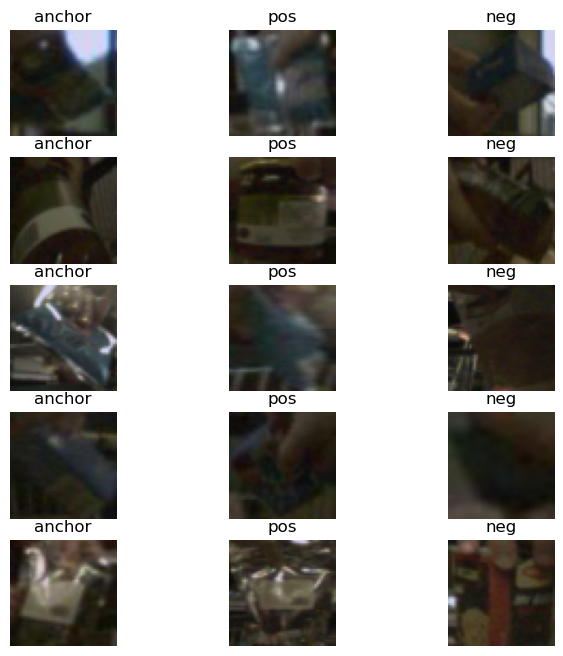

In [4]:
data_root = "/home/walter/git/Siamese_object_recognition/data/training"
img_folder_ds = ds.ImageFolder(root=data_root)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=img_folder_ds,
                                        transform=transforms.Resize((50,50)))
imshow(siamese_dataset, 5)

In [5]:
data_root = "/home/walter/git/Siamese_object_recognition/data/training"
img_folder_ds = ds.ImageFolder(root=data_root)

## MODEL

In [6]:
from torchvision import models
from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights

class SiameseNetwork(nn.Module):
    def __init__(self, backbone="resnet50"):
        super(SiameseNetwork, self).__init__()
        self.backbone = efficientnet_b2(weights=EfficientNet_B2_Weights)
        
        self.cls_head = nn.Sequential(
            nn.Linear(1000, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(64, 10),
        )

    def forward_once(self, x):
        output = self.backbone(x)
        output = output.view(output.size()[0], -1)
        output = self.cls_head(output)
        return output

    def forward(self, anchor, pos, neg):
        anchor_out = self.forward_once(anchor)
        pos_out = self.forward_once(pos)
        neg_out = self.forward_once(neg)
        return anchor_out, pos_out, neg_out

In [7]:
class TripletLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = F.pairwise_distance(anchor, positive, keepdim = True)
        distance_negative = F.pairwise_distance(anchor, negative, keepdim = True)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()

## Training 

In [8]:
# cpu count 
import multiprocessing
num_cores = multiprocessing.cpu_count()
print("Number of CPU cores:", num_cores)

# siamese dataset and dataloader
train_dataset_root = os.getcwd() + "/data/training/"
imgs_folder_dataset = ds.ImageFolder(root=train_dataset_root)
transform=transforms.Compose([
    transforms.Resize((224,224),antialias=True),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]),
    ])
train_dataset = SiameseNetworkDataset(imgs_folder_dataset, transform=transform)
train_dataloader = DataLoader(train_dataset,
                        shuffle=True,
                        num_workers=num_cores-1,
                        batch_size=32)

Number of CPU cores: 36


In [9]:
# training config 
model = SiameseNetwork().cuda()
criterion = TripletLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_epoch = 50
epoches = []
loss_history = []

/home/walter/miniconda3/envs/siamese/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /home/walter/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth
66.6%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [10]:
# training loop 
for epoch in range(1, train_epoch+1):
    for batch in train_dataloader:
        anchor, pos, neg = batch
        anchor, pos, neg = anchor.cuda(), pos.cuda(), neg.cuda()
        optimizer.zero_grad()
        anchor_out, pos_out, neg_out = model(anchor, pos, neg)
        triplet_loss = criterion(anchor_out, pos_out, neg_out)
        triplet_loss.backward()
        optimizer.step()
    print("Epoch number {}\n Current loss {}\n".format(epoch, triplet_loss.item()))
    epoches.append(epoch)
    loss_history.append(triplet_loss.item())

Epoch number 1
 Current loss 1.7839758396148682

Epoch number 2
 Current loss 1.5573419332504272

Epoch number 3
 Current loss 0.9463708400726318

Epoch number 4
 Current loss 1.0800681114196777

Epoch number 5
 Current loss 0.8541445732116699

Epoch number 6
 Current loss 0.931157112121582

Epoch number 7
 Current loss 0.4013538360595703

Epoch number 8
 Current loss 0.33886387944221497

Epoch number 9
 Current loss 1.2622617483139038

Epoch number 10
 Current loss 0.7283597588539124

Epoch number 11
 Current loss 1.0930060148239136

Epoch number 12
 Current loss 1.0296577215194702

Epoch number 13
 Current loss 0.727641761302948

Epoch number 14
 Current loss 1.8231028318405151

Epoch number 15
 Current loss 0.801680862903595

Epoch number 16
 Current loss 0.16932007670402527

Epoch number 17
 Current loss 0.09049264341592789

Epoch number 18
 Current loss 0.33923834562301636

Epoch number 19
 Current loss 0.2263442426919937

Epoch number 20
 Current loss 0.7793921828269958

Epoch nu

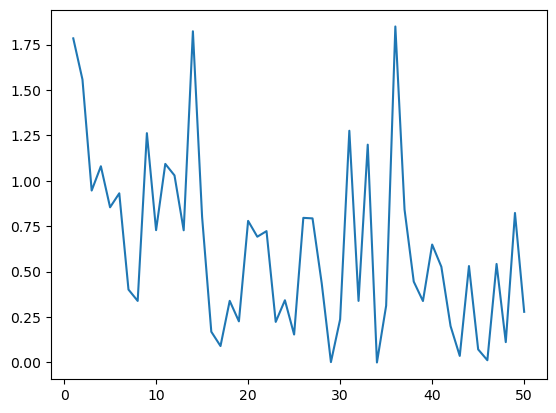

In [11]:
show_plot(epoches,loss_history)
torch.save(model.state_dict(), 'triplet_model_weights.pth')

## EVAL

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
testset_root = os.getcwd() + "/data/testing/"
imgs_folder_dataset = ds.ImageFolder(root=testset_root)
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224),antialias=True),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]),
    ])

test_dataset = SiameseNetworkDataset(imgs_folder_dataset, transform=transform)
test_dataloader = DataLoader(test_dataset,
                        shuffle=False,
                        num_workers=num_cores-1,
                        batch_size=1)

checkpoint = torch.load('triplet_model_weights.pth')
model = SiameseNetwork()
model.to(device)
model.load_state_dict(checkpoint)
model.eval()

SiameseNetwork(
  (backbone): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (sca

In [13]:
criterion = TripletLoss()
correct = 0
total = 0

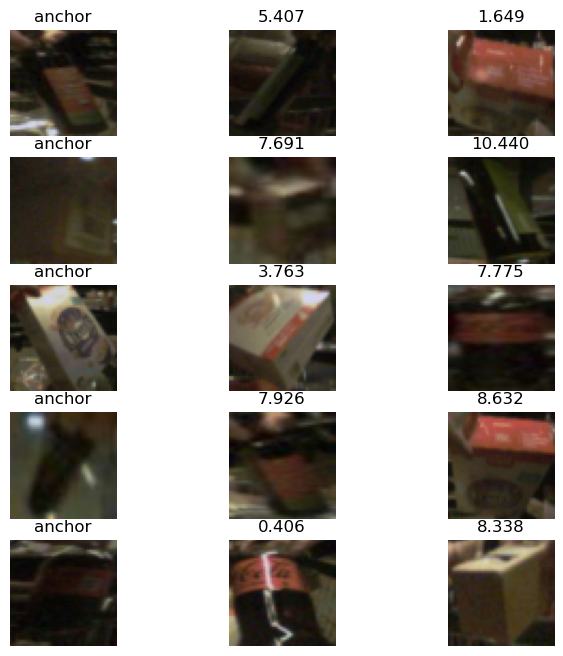

In [21]:
num_pair = 5
testset_root = os.getcwd() + "/data/testing/"
imgs_folder_dataset = ds.ImageFolder(root=testset_root)
test_dataset = SiameseNetworkDataset(imgs_folder_dataset, transform=None)
inf_transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224),antialias=True),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]),
    ])
show_transformer = transforms.Resize((50,50))
cols = 3
rows = num_pair
figure = plt.figure(figsize=(8, 8))
for i in range(num_pair):
    anchor, pos, neg = test_dataset[i]
    anchor_inf, pos_inf, neg_inf = map(lambda x: inf_transformer(x), [anchor, pos, neg])
    anchor_inf, pos_inf, neg_inf = map(lambda x: x.cuda(), [anchor_inf, pos_inf, neg_inf])
    anchor_inf, pos_inf, neg_inf = map(lambda x: torch.unsqueeze(x,0), [anchor_inf, pos_inf, neg_inf])
    anchor_show, pos_show, neg_show = map(lambda x: show_transformer(x), [anchor, pos, neg])    
    anchor_out, pos_out, neg_out = model(anchor_inf, pos_inf, neg_inf)
    pos_distance = "{:.3f}".format(F.pairwise_distance(anchor_out, pos_out).item())
    neg_distance = "{:.3f}".format(F.pairwise_distance(anchor_out, neg_out).item()) 
    
    # show 
    col_1 = figure.add_subplot(rows, cols, 3 * i + 1)
    col_1.set_title("anchor")
    plt.axis("off")
    plt.imshow(np.asarray(anchor_show))
    col_2 = figure.add_subplot(rows, cols, 3 * i + 2)
    col_2.set_title(f"{pos_distance}")
    plt.axis("off")
    plt.imshow(np.asarray(pos_show))
    col_3 = figure.add_subplot(rows, cols, 3 * i + 3)
    col_3.set_title(f"{neg_distance}")
    plt.axis("off")
    plt.imshow(np.asarray(neg_show))
    plt.axis("off")
plt.show()

In [19]:
for anchor, pos, neg in test_dataloader:
    anchor, pos, neg = map(lambda x: x.to(device), [anchor, pos, neg])
    anchor_out, pos_out, neg_out = model(anchor, pos, neg)
#     print(anchor_out)
#     print(pos_out)
#     print(neg_out)
    
    pos_distance = F.pairwise_distance(anchor_out, pos_out)
    neg_distance = F.pairwise_distance(anchor_out, neg_out)
    correct += int(pos_distance.item() < 5)
    correct += int(neg_distance.item() > 5)
    total += 2

print(correct / total * 100)

tensor([0.], device='cuda:0')
68.41317365269461
